In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from google.colab import files
# You need to have kaggle.json downloaded from your kaggle account, then upload it here.
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [3]:
!kaggle datasets download -d stephengoldie/big-databiopharmaceutical-manufacturing

 99% 667M/677M [00:10<00:00, 82.1MB/s]
100% 677M/677M [00:10<00:00, 66.5MB/s]


In [4]:
!unzip big-databiopharmaceutical-manufacturing.zip

Archive:  big-databiopharmaceutical-manufacturing.zip
  inflating: Mendeley_data/100_Batches_IndPenSim_Statistics.csv  
  inflating: Mendeley_data/100_Batches_IndPenSim_V3.csv  


This data was generated using an advanced mathematical simulation of a 100,000 litre penicillin fermentation system referenced as IndPenSim. All details describing the simulation are available on the following website: www.industrialpenicillinsimulation.com. **IndPenSim **is the first simulation to include a realistic simulated Raman spectroscopy device for the purpose of developing, evaluating and implementation of advanced and innovative control solutions applicable to biotechnology facilities. This data set generated by IndPenSim represents the biggest data set available for advanced data analytics and contains 100 batches with all available process and Raman spectroscopy measurements (~2.5 GB). This data is highly suitable for the development of big data analytics, machine learning (ML) or artificial intelligence (AI) algorithms applicable to the biopharmaceutical industry. The 100 batches are controlled using different control strategies and different batch lengths representing a typical Biopharmaceutical manufacturing facility:

Batches 1-30: Controlled by recipe driven approach Batches 31-60: Controlled by operators Batches 61:90: Controlled by an Advanced Process Control (APC) solution using the Raman spectroscopy Batches 91:100: Contain faults resulting in process deviations.

**The linked images or graphs are from my Tableau project**

![ Image of synthesis process](https://i.imgur.com/6nevMNw.png)

In [0]:
raw_data = pd.read_csv('Mendeley_data/100_Batches_IndPenSim_V3.csv')

In [6]:
raw_data.head()

,Time (h),Aeration rate(Fg:L/h),Agitator RPM(RPM:RPM),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),Dumped broth flow(Fremoved:L/h),Substrate concentration(S:g/L),Dissolved oxygen concentration(DO2:mg/L),Penicillin concentration(P:g/L),Vessel Volume(V:L),Vessel Weight(Wt:Kg),pH(pH:pH),Temperature(T:K),Generated heat(Q:kJ),carbon dioxide percent in off-gas(CO2outgas:%),PAA flow(Fpaa:PAA flow (L/h)),PAA concentration offline(PAA_offline:PAA (g L^{-1})),Oil flow(Foil:L/hr),NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1})),Oxygen Uptake Rate(OUR:(g min^{-1})),Oxygen in percent in off-gas(O2:O2 (%)),Offline Penicillin concentration(P_offline:P(g L^{-1})),Offline Biomass concentratio(X_offline:X(g L^{-1})),Carbon evolution rate(CER:g/h),Ammonia shots(NH3_shots:kgs),Viscosity(Viscosity_offline:centPoise),Fault reference(Fault_ref:Fault ref),0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref),1- No Raman spec,1-Raman spec recorded,2-PAT control(PAT_ref:PAT ref),Batch reference(Batch_ref:Batch ref),Batch ID,Fault flag,2400,...,240,239,238,237,236,235,234,233,232,231,230,229,228,227,226,225,224,223,222,221,220,219,218,217,216,215,214,213,212,211,210,209,208,207,206,205,204,203,202,201
0,0.2,30,100,8,0.0000,30.118,9.8335,0.0001,0,0.6,0,0.95749,14.711,1.017800e-25,58479,62574.0,6.4472,298.22,0.000001,0.089514,5.0,NaN,22,NaN,0.480510,0.19595,NaN,NaN,0.034045,0,NaN,0,0,1,1,1,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,0.4,30,100,8,0.0000,51.221,18.1550,0.0001,0,0.6,0,1.00460,14.699,1.000000e-03,58487,62585.0,6.4932,298.17,0.000001,0.101760,5.0,NaN,22,NaN,0.058147,0.20390,NaN,NaN,0.038702,0,NaN,0,0,1,1,1,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,0.6,30,100,8,0.0000,54.302,9.5982,0.0001,0,0.6,0,1.04980,14.686,9.993400e-04,58495,62598.0,6.5425,298.14,0.000001,0.105800,5.0,NaN,22,NaN,-0.041505,0.20575,NaN,NaN,0.040240,0,NaN,0,0,1,1,1,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,0.8,30,100,8,0.0000,37.816,4.3395,0.0001,0,0.6,0,1.09420,14.661,9.987400e-04,58499,62607.0,6.5753,298.11,0.000001,0.108190,5.0,NaN,22,NaN,-0.056737,0.20602,NaN,NaN,0.041149,0,NaN,0,0,1,1,1,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,1.0,30,100,8,0.5181,18.908,1.1045,0.0001,0,0.6,0,1.13700,14.633,9.982100e-04,58501,62613.0,6.5825,298.09,0.000001,0.110300,5.0,1488.0,22,1667.8,-0.049975,0.20589,1.017800e-25,0.52808,0.041951,0,4.083,0,0,1,1,1,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [7]:
raw_data.info

<bound method DataFrame.info of         Time (h)  Aeration rate(Fg:L/h)  ...  202  201
0            0.2                     30  ...  NaN  NaN
1            0.4                     30  ...  NaN  NaN
2            0.6                     30  ...  NaN  NaN
3            0.8                     30  ...  NaN  NaN
4            1.0                     30  ...  NaN  NaN
...          ...                    ...  ...  ...  ...
113930     229.2                     65  ...  NaN  NaN
113931     229.4                     65  ...  NaN  NaN
113932     229.6                     65  ...  NaN  NaN
113933     229.8                     65  ...  NaN  NaN
113934     230.0                     65  ...  NaN  NaN

[113935 rows x 2239 columns]>

In [0]:
raw_stats = pd.read_csv('Mendeley_data/100_Batches_IndPenSim_Statistics.csv')

In [9]:
raw_stats.head()

,Batch ref,Penicllin_harvested_during_batch(kg),Penicllin_harvested_end_of_batch (kg),Penicllin_yield_total (kg),Fault ref(0-NoFault 1-Fault)
0,1,1066400.0,1720000.0,2786400.0,0
1,2,985910.0,1340100.0,2326000.0,0
2,3,1416100.0,1259200.0,2675300.0,0
3,4,815700.0,1071000.0,1886700.0,0
4,5,1128500.0,2434400.0,3562900.0,0


In [10]:
#Splitting the feature data from the raman spec data
variable_raman_data = np.split(raw_data, [raw_data.columns.get_loc("2400")], axis=1)
variable_data = variable_raman_data[0]
variable_data.describe()

,Time (h),Aeration rate(Fg:L/h),Agitator RPM(RPM:RPM),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),Dumped broth flow(Fremoved:L/h),Substrate concentration(S:g/L),Dissolved oxygen concentration(DO2:mg/L),Penicillin concentration(P:g/L),Vessel Volume(V:L),Vessel Weight(Wt:Kg),pH(pH:pH),Temperature(T:K),Generated heat(Q:kJ),carbon dioxide percent in off-gas(CO2outgas:%),PAA flow(Fpaa:PAA flow (L/h)),PAA concentration offline(PAA_offline:PAA (g L^{-1})),Oil flow(Foil:L/hr),NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1})),Oxygen Uptake Rate(OUR:(g min^{-1})),Oxygen in percent in off-gas(O2:O2 (%)),Offline Penicillin concentration(P_offline:P(g L^{-1})),Offline Biomass concentratio(X_offline:X(g L^{-1})),Carbon evolution rate(CER:g/h),Ammonia shots(NH3_shots:kgs),Viscosity(Viscosity_offline:centPoise),Fault reference(Fault_ref:Fault ref),0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref),1- No Raman spec,1-Raman spec recorded,2-PAT control(PAT_ref:PAT ref),Batch reference(Batch_ref:Batch ref),Batch ID,Fault flag
count,113935.000000,113935.000000,113935.0,113935.000000,113935.000000,113935.000000,113935.000000,113935.000000,113935.000000,113935.000000,113935.000000,113935.000000,113935.000000,1.139350e+05,113935.000000,113935.000000,113935.000000,113935.000000,113935.000000,113935.000000,113935.000000,2062.000000,113935.000000,2062.000000,113935.000000,113935.000000,2.062000e+03,2062.000000,113935.000000,113935.0,2062.000000,113935.000000,113935.000000,113935.000000,113935.000000,113935.000000,113935.000000,113935.000000,113935.000000
mean,114.750656,65.246360,100.0,76.663764,0.073209,61.334389,74.346341,20.763025,154.811954,0.945026,-214.508272,4.079817,12.569647,1.433395e+01,73312.865441,81076.728512,6.496565,298.026489,279.072562,1.444042,7.642712,1887.750349,26.352789,1961.843259,1.258208,0.191458,1.443945e+01,18.799095,1.250103,0.0,51.546454,0.011024,0.301795,1.295783,50.402466,50.402466,0.101154,89307.003616,89402.127915
std,66.990504,11.690215,0.0,25.680134,0.552788,44.972713,108.022600,50.230266,155.601474,0.134269,901.125084,13.303517,1.498680,9.932453e+00,8599.642160,10097.227390,0.065676,0.197513,139.982445,0.498955,3.560204,1581.477997,4.954933,542.287061,0.463273,0.004718,1.026091e+01,7.016321,0.484094,0.0,24.073778,0.104415,0.459039,0.456396,28.862140,28.862140,0.301534,47765.751082,47852.683115
min,0.200000,20.000000,100.0,2.000000,0.000000,0.000000,0.000100,0.000100,0.000000,0.600000,-4000.000000,0.000006,1.000000,3.694700e-26,56549.000000,60395.000000,5.395700,296.840000,0.000001,0.075425,0.000000,393.100000,22.000000,1391.600000,-1.242000,0.129500,3.694700e-26,0.393810,0.028685,0.0,4.075300,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,57.000000,60.000000,100.0,72.000000,0.000000,35.766000,11.157000,0.000100,0.000000,0.900000,0.000000,0.001025,11.639000,5.531250e+00,65885.500000,73018.500000,6.493200,297.950000,177.000000,1.225900,5.844400,1198.500000,23.000000,1693.575000,1.014000,0.188860,5.336925e+00,16.626000,0.978110,0.0,34.812250,0.000000,0.000000,1.000000,26.000000,26.000000,0.000000,47016.500000,47029.500000
50%,114.000000,65.000000,100.0,80.000000,0.000000,55.407000,34.384000,0.159010,100.000000,0.900000,0.000000,0.001644,12.636000,1.438000e+01,75770.000000,84367.000000,6.500900,297.990000,276.780000,1.596300,9.791200,1263.300000,23.000000,1790.900000,1.265800,0.191180,1.456700e+01,21.449000,1.402600,0.0,53.154000,0.000000,0.000000,1.000000,50.000000,50.000000,0.000000,89699.000000,89772.000000
75%,171.000000,75.000000,100.0,90.000000,0.000000,76.271500,94.904500,11.640500,250.000000,1.100000,0.000000,0.003003,13.614000,2.268750e+01,79892.000000,88608.000000,6.508600,298.040000,364.565000,1.757300,10.000000,1790.900000,30.000000,1918.700000,1.603600,0.193660,2.311275e+01,23.672250,1.621450,0.

In [11]:
variable_data.head()

,Time (h),Aeration rate(Fg:L/h),Agitator RPM(RPM:RPM),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),Dumped broth flow(Fremoved:L/h),Substrate concentration(S:g/L),Dissolved oxygen concentration(DO2:mg/L),Penicillin concentration(P:g/L),Vessel Volume(V:L),Vessel Weight(Wt:Kg),pH(pH:pH),Temperature(T:K),Generated heat(Q:kJ),carbon dioxide percent in off-gas(CO2outgas:%),PAA flow(Fpaa:PAA flow (L/h)),PAA concentration offline(PAA_offline:PAA (g L^{-1})),Oil flow(Foil:L/hr),NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1})),Oxygen Uptake Rate(OUR:(g min^{-1})),Oxygen in percent in off-gas(O2:O2 (%)),Offline Penicillin concentration(P_offline:P(g L^{-1})),Offline Biomass concentratio(X_offline:X(g L^{-1})),Carbon evolution rate(CER:g/h),Ammonia shots(NH3_shots:kgs),Viscosity(Viscosity_offline:centPoise),Fault reference(Fault_ref:Fault ref),0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref),1- No Raman spec,1-Raman spec recorded,2-PAT control(PAT_ref:PAT ref),Batch reference(Batch_ref:Batch ref),Batch ID,Fault flag
0,0.2,30.0,100.0,8.0,0.0000,30.118,9.8335,0.0001,0.0,0.6,0.0,0.95749,14.711,1.017800e-25,58479.0,62574.0,6.4472,298.22,0.000001,0.089514,5.0,NaN,22.0,NaN,0.480510,0.19595,NaN,NaN,0.034045,0.0,NaN,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
1,0.4,30.0,100.0,8.0,0.0000,51.221,18.1550,0.0001,0.0,0.6,0.0,1.00460,14.699,1.000000e-03,58487.0,62585.0,6.4932,298.17,0.000001,0.101760,5.0,NaN,22.0,NaN,0.058147,0.20390,NaN,NaN,0.038702,0.0,NaN,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
2,0.6,30.0,100.0,8.0,0.0000,54.302,9.5982,0.0001,0.0,0.6,0.0,1.04980,14.686,9.993400e-04,58495.0,62598.0,6.5425,298.14,0.000001,0.105800,5.0,NaN,22.0,NaN,-0.041505,0.20575,NaN,NaN,0.040240,0.0,NaN,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3,0.8,30.0,100.0,8.0,0.0000,37.816,4.3395,0.0001,0.0,0.6,0.0,1.09420,14.661,9.987400e-04,58499.0,62607.0,6.5753,298.11,0.000001,0.108190,5.0,NaN,22.0,NaN,-0.056737,0.20602,NaN,NaN,0.041149,0.0,NaN,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
4,1.0,30.0,100.0,8.0,0.5181,18.908,1.1045,0.0001,0.0,0.6,0.0,1.13700,14.633,9.982100e-04,58501.0,62613.0,6.5825,298.09,0.000001,0.110300,5.0,1488.0,22.0,1667.8,-0.049975,0.20589,1.017800e-25,0.52808,0.041951,0.0,4.083,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0


In [0]:
variable_data = variable_data.rename(columns={'2-PAT control(PAT_ref:PAT ref)': 'Batch reference(Batch_ref:Batch ref)',
                                              'Batch reference(Batch_ref:Batch ref)':'2-PAT control(PAT_ref:PAT ref)'})

In [0]:
raman_spectra = variable_raman_data[1]

In [14]:
raman_spectra.head()

,2400,2399,2398,2397,2396,2395,2394,2393,2392,2391,2390,2389,2388,2387,2386,2385,2384,2383,2382,2381,2380,2379,2378,2377,2376,2375,2374,2373,2372,2371,2370,2369,2368,2367,2366,2365,2364,2363,2362,2361,...,240,239,238,237,236,235,234,233,232,231,230,229,228,227,226,225,224,223,222,221,220,219,218,217,216,215,214,213,212,211,210,209,208,207,206,205,204,203,202,201
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [0]:
batch_ref_df = variable_data[['Batch reference(Batch_ref:Batch ref)']]

In [0]:
raman_spectra_batch_id = pd.concat([batch_ref_df, raman_spectra], axis=1)

In [17]:
raman_spectra_batch_id.head()

,Batch reference(Batch_ref:Batch ref),2400,2399,2398,2397,2396,2395,2394,2393,2392,2391,2390,2389,2388,2387,2386,2385,2384,2383,2382,2381,2380,2379,2378,2377,2376,2375,2374,2373,2372,2371,2370,2369,2368,2367,2366,2365,2364,2363,2362,...,240,239,238,237,236,235,234,233,232,231,230,229,228,227,226,225,224,223,222,221,220,219,218,217,216,215,214,213,212,211,210,209,208,207,206,205,204,203,202,201
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [0]:
variable_list = variable_data.columns

In [19]:
variable_plot_selection = widgets.Dropdown(options=variable_list, value = 'Penicillin concentration(P:g/L)')
variable_plot_selection

Dropdown(index=13, options=('Time (h)', 'Aeration rate(Fg:L/h)', 'Agitator RPM(RPM:RPM)', 'Sugar feed rate(Fs:…

Text(0, 0.5, 'Penicillin concentration(P:g/L)')

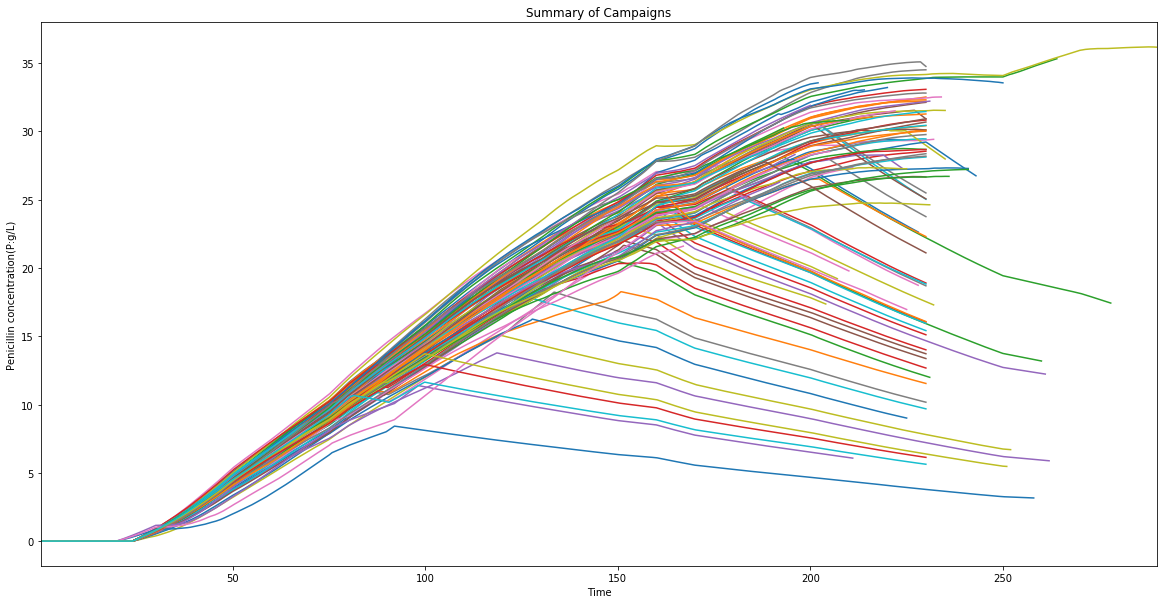

In [20]:
fig, ax = plt.subplots(figsize=(20,10))
bp = variable_data.groupby('Batch reference(Batch_ref:Batch ref)').plot(x = 'Time (h)', y = variable_plot_selection.value,   ax=ax, legend = False, )
ax.set_title('Summary of Campaigns')
ax.set_xlabel('Time')
ax.set_ylabel(variable_plot_selection.value)

In [0]:
raman_data = variable_data.groupby('Batch reference(Batch_ref:Batch ref)').get_group(1)

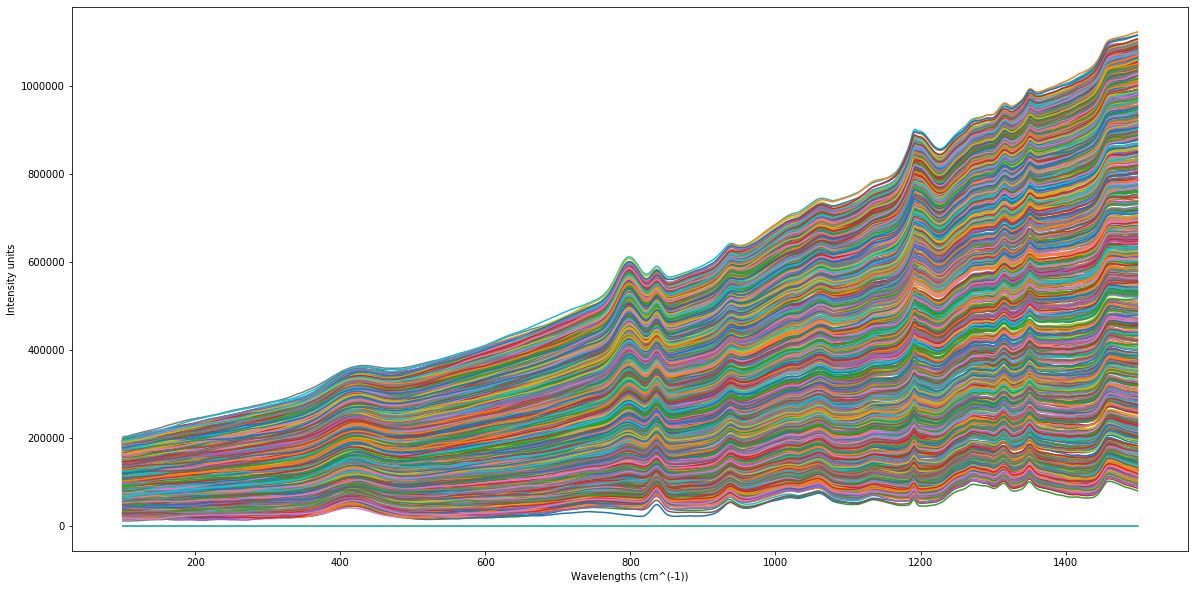

In [22]:
plt.figure(figsize=(20,10))
Intensity = raman_spectra.iloc[100:1208, 100:1500]
x_wave = raman_spectra.index[100:1500]
Temp = Intensity.transpose()
plt.plot(x_wave,Temp)
plt.ylabel('Intensity units')
plt.xlabel('Wavelengths (cm^(-1))')
plt.show()

![alt text](https://i.imgur.com/Y7qpbI6.jpghttps://i.imgur.com/Y7qpbI6.jpg)
![alt text](https://i.imgur.com/OZBznk5.jpg)

In [23]:
variable_data.isnull().sum()*100/variable_data.isnull().count()

Time (h)                                                               0.000000
Aeration rate(Fg:L/h)                                                  0.000000
Agitator RPM(RPM:RPM)                                                  0.000000
Sugar feed rate(Fs:L/h)                                                0.000000
Acid flow rate(Fa:L/h)                                                 0.000000
Base flow rate(Fb:L/h)                                                 0.000000
Heating/cooling water flow rate(Fc:L/h)                                0.000000
Heating water flow rate(Fh:L/h)                                        0.000000
Water for injection/dilution(Fw:L/h)                                   0.000000
Air head pressure(pressure:bar)                                        0.000000
Dumped broth flow(Fremoved:L/h)                                        0.000000
Substrate concentration(S:g/L)                                         0.000000
Dissolved oxygen concentration(DO2:mg/L)

There are 5 features here that are over 98% null values. They are all offline measurements of the corresponding type. This study isn't about the offline measurements, so between it not mattering and there being too many null values to impute the data I am going to drop the features. I am also removing some of the features that are irrellevant for these tests.

In [0]:
variable_data.drop(columns=['PAA concentration offline(PAA_offline:PAA (g L^{-1}))',
                            'NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))', 
                            'Offline Penicillin concentration(P_offline:P(g L^{-1}))',
                            'Offline Biomass concentratio(X_offline:X(g L^{-1}))',
                            'Viscosity(Viscosity_offline:centPoise)',
                            'Batch ID', 'Fault flag', 
                            '2-PAT control(PAT_ref:PAT ref)', '1- No Raman spec', 
                            'Fault reference(Fault_ref:Fault ref)', 
                            'Ammonia shots(NH3_shots:kgs)', ' 1-Raman spec recorded',
                            '0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref)'], inplace=True)

Creating a new column that will allow me to select the different control groups for comparison.

In [0]:
def control_type(x):
  if x < 31:
    return 'recipe'
  elif x < 61:
    return 'operators'
  elif x < 91:
    return 'APC'
  else:
    return 'faults'

In [0]:
variable_data['control_type'] = raman_spectra_batch_id['Batch reference(Batch_ref:Batch ref)'].apply(control_type)

In [0]:
variable_data_recipe = variable_data.loc[variable_data.control_type == 'recipe']
variable_data_operators = variable_data.loc[variable_data.control_type == 'operators']
variable_data_APC = variable_data.loc[variable_data.control_type == 'APC']
# We now have 3 data frames, 1 for each control type

In [0]:
from google.colab import files
import pandas_profiling

In [0]:
def google_csv(x):
  x.to_csv('temp.csv')
  files.download('temp.csv')

In [0]:
google_csv(variable_data_recipe)
# This will download a csv of whatever is passed.

In [30]:
pandas_profiling.ProfileReport(variable_data_recipe)

Number of variables,27
Number of observations,34325
Total Missing (%),0.0%
Total size in memory,7.3 MiB
Average record size in memory,224.0 B
Numeric,22
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,4


In [31]:
variable_data_recipe.corr()

,Time (h),Aeration rate(Fg:L/h),Agitator RPM(RPM:RPM),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),Dumped broth flow(Fremoved:L/h),Substrate concentration(S:g/L),Dissolved oxygen concentration(DO2:mg/L),Penicillin concentration(P:g/L),Vessel Volume(V:L),Vessel Weight(Wt:Kg),pH(pH:pH),Temperature(T:K),Generated heat(Q:kJ),carbon dioxide percent in off-gas(CO2outgas:%),PAA flow(Fpaa:PAA flow (L/h)),Oil flow(Foil:L/hr),Oxygen Uptake Rate(OUR:(g min^{-1})),Oxygen in percent in off-gas(O2:O2 (%)),Carbon evolution rate(CER:g/h),Batch reference(Batch_ref:Batch ref)
Time (h),1.000000,0.655670,NaN,0.433423,0.108776,-0.257773,-0.442401,0.303061,0.211847,0.092912,-0.166460,0.429976,-0.225468,0.879622,0.554251,0.609648,-0.000267,-0.313339,-0.044340,0.504309,0.265024,-0.733514,-0.022256,0.153460,0.566872,0.029173
Aeration rate(Fg:L/h),0.655670,1.000000,NaN,0.660202,0.030450,-0.025233,-0.420481,0.108153,0.152659,0.514689,-0.155621,0.049066,-0.242110,0.721695,0.787337,0.815504,-0.021195,-0.291906,-0.080904,0.799905,0.686520,-0.599797,0.466095,-0.246363,0.901262,-0.000115
Agitator RPM(RPM:RPM),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sugar feed rate(Fs:L/h),0.433423,0.660202,NaN,1.000000,-0.006330,0.282613,-0.134837,-0.000538,0.184075,0.480509,-0.083208,0.032181,-0.196088,0.467464,0.662596,0.671843,-0.088843,-0.132328,-0.030426,0.699836,0.492631,-0.378813,0.633414,-0.565871,0.688600,0.002401
Acid flow rate(Fa:L/h),0.108776,0.030450,NaN,-0.006330,1.000000,-0.170288,-0.002790,0.087750,-0.015215,-0.053538,-0.162114,0.195311,0.042529,0.013968,-0.041821,-0.031323,0.236262,0.010778,0.026641,-0.045185,-0.017072,-0.066414,-0.140563,0.149019,-0.030053,0.003489
Base flow rate(Fb:L/h),-0.257773,-0.025233,NaN,0.282613,-0.170288,1.000000,0.257874,-0.102772,0.058492,0.124831,0.195483,-0.383511,-0.138057,-0.102593,0.061780,0.036817,-0.402280,0.133879,0.093736,0.106702,0.014991,0.267002,0.405738,-0.459743,0.048265,-0.073598
Heating/cooling water flow rate(Fc:L/h),-0.442401,-0.420481,NaN,-0.134837,-0.002790,0.257874,1.000000,-0.186962,-0.300481,-0.260765,0.093535,-0.047950,-0.075563,-0.502353,-0.494772,-0.507549,-0.054416,0.503771,0.155449,-0.444663,-0.474728,0.511581,-0.010114,-0.131018,-0.499530,0.027317
Heating water flow rate(Fh:L/h),0.303061,0.108153,NaN,-0.000538,0.087750,-0.102772,-0.186962,1.000000,0.066857,-0.120134,-0.031680,0.214099,-0.036961,0.215577,0.047901,0.070202,0.020571,0.477367,0.214128,0.017649,-0.039679,-0.186345,-0.193464,0.219481,0.043384,-0.010398
Water for injection/dilution(Fw:L/h),0.211847,0.152659,NaN,0.184075,-0.015215,0.058492,-0.300481,0.066857,1.000000,0.402594,0.049710,0.093073,0.358842,0.164175,0.199279,0.210354,0.003373,-0.165972,-0.040521,0.317012,0.323546,0.046125,-0.091723,0.047398,0.225067,-0.000430
Air head pressure(pressure:bar),0.092912,0.514689,NaN,0.480509,-0.053538,0.124831,-0.260765,-0.120134,0.402594,1.000000,0.021902,-0.119308,0.270347,0.145110,0.541818,0.537699,0.048397,-0.156395,-0.042552,0.751723,0.722478,-0.027242,0.579627,-0.543327,0.641629,-0.005572


In [32]:
variable_data_recipe.drop(columns=['control_type'], inplace=True)
variable_data_operators.drop(columns=['control_type'], inplace=True)
variable_data_APC.drop(columns=['control_type'], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [33]:
variable_data_recipe.head()

,Time (h),Aeration rate(Fg:L/h),Agitator RPM(RPM:RPM),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),Dumped broth flow(Fremoved:L/h),Substrate concentration(S:g/L),Dissolved oxygen concentration(DO2:mg/L),Penicillin concentration(P:g/L),Vessel Volume(V:L),Vessel Weight(Wt:Kg),pH(pH:pH),Temperature(T:K),Generated heat(Q:kJ),carbon dioxide percent in off-gas(CO2outgas:%),PAA flow(Fpaa:PAA flow (L/h)),Oil flow(Foil:L/hr),Oxygen Uptake Rate(OUR:(g min^{-1})),Oxygen in percent in off-gas(O2:O2 (%)),Carbon evolution rate(CER:g/h),Batch reference(Batch_ref:Batch ref)
0,0.2,30.0,100.0,8.0,0.0000,30.118,9.8335,0.0001,0.0,0.6,0.0,0.95749,14.711,1.017800e-25,58479.0,62574.0,6.4472,298.22,0.000001,0.089514,5.0,22.0,0.480510,0.19595,0.034045,1.0
1,0.4,30.0,100.0,8.0,0.0000,51.221,18.1550,0.0001,0.0,0.6,0.0,1.00460,14.699,1.000000e-03,58487.0,62585.0,6.4932,298.17,0.000001,0.101760,5.0,22.0,0.058147,0.20390,0.038702,1.0
2,0.6,30.0,100.0,8.0,0.0000,54.302,9.5982,0.0001,0.0,0.6,0.0,1.04980,14.686,9.993400e-04,58495.0,62598.0,6.5425,298.14,0.000001,0.105800,5.0,22.0,-0.041505,0.20575,0.040240,1.0
3,0.8,30.0,100.0,8.0,0.0000,37.816,4.3395,0.0001,0.0,0.6,0.0,1.09420,14.661,9.987400e-04,58499.0,62607.0,6.5753,298.11,0.000001,0.108190,5.0,22.0,-0.056737,0.20602,0.041149,1.0
4,1.0,30.0,100.0,8.0,0.5181,18.908,1.1045,0.0001,0.0,0.6,0.0,1.13700,14.633,9.982100e-04,58501.0,62613.0,6.5825,298.09,0.000001,0.110300,5.0,22.0,-0.049975,0.20589,0.041951,1.0


In [34]:
variable_data_recipe.columns

Index(['Time (h)', 'Aeration rate(Fg:L/h)', 'Agitator RPM(RPM:RPM)',
       'Sugar feed rate(Fs:L/h)', 'Acid flow rate(Fa:L/h)',
       'Base flow rate(Fb:L/h)', 'Heating/cooling water flow rate(Fc:L/h)',
       'Heating water flow rate(Fh:L/h)',
       'Water for injection/dilution(Fw:L/h)',
       'Air head pressure(pressure:bar)', 'Dumped broth flow(Fremoved:L/h)',
       'Substrate concentration(S:g/L)',
       'Dissolved oxygen concentration(DO2:mg/L)',
       'Penicillin concentration(P:g/L)', 'Vessel Volume(V:L)',
       'Vessel Weight(Wt:Kg)', 'pH(pH:pH)', 'Temperature(T:K)',
       'Generated heat(Q:kJ)',
       'carbon dioxide percent in off-gas(CO2outgas:%)',
       'PAA flow(Fpaa:PAA flow (L/h))', 'Oil flow(Foil:L/hr)',
       'Oxygen Uptake Rate(OUR:(g min^{-1}))',
       'Oxygen in percent in off-gas(O2:O2  (%))',
       'Carbon evolution rate(CER:g/h)',
       'Batch reference(Batch_ref:Batch ref)'],
      dtype='object')

In [0]:
#new dataframe to hold the results of all my models for comparison
scores = pd.DataFrame()

Taking the difference of the data to stationarize the time series.

In [0]:
#creating new dataframes that have the time series stationarized
var_rec_diff = variable_data_recipe.drop(columns=['Time (h)', 'Batch reference(Batch_ref:Batch ref)']).diff()
var_op_diff = variable_data_operators.drop(columns=['Time (h)', 'Batch reference(Batch_ref:Batch ref)']).diff()
var_APC_diff = variable_data_APC.drop(columns=['Time (h)', 'Batch reference(Batch_ref:Batch ref)']).diff()
#dropping time because once it is stationarized I won't need it, dropping batch reference because I have already extracted the control groups from that data

In [0]:
var_rec_diff.dropna(inplace=True)
var_op_diff.dropna(inplace=True)
var_APC_diff.dropna(inplace=True)

In [0]:
rfr = ensemble.RandomForestRegressor(random_state=42)
X_r = var_rec_diff.drop(columns=['Penicillin concentration(P:g/L)'])
Y_r = var_rec_diff['Penicillin concentration(P:g/L)']
X_o = var_op_diff.drop(columns=['Penicillin concentration(P:g/L)'])
Y_o = var_op_diff['Penicillin concentration(P:g/L)']
X_a = var_APC_diff.drop(columns=['Penicillin concentration(P:g/L)'])
Y_a = var_APC_diff['Penicillin concentration(P:g/L)']

In [0]:
scores['rfr_recipe'] = cross_val_score(rfr, X_r, Y_r, cv=10)
scores['rfr_operator'] = cross_val_score(rfr, X_o, Y_o, cv=10)
scores['rfr_APC'] = cross_val_score(rfr, X_a, Y_a, cv=10)

In [41]:
scores

,rfr_recipe,rfr_operator,rfr_APC
0,0.997040,0.990087,0.996671
1,0.915045,0.922718,0.996517
2,0.996569,0.976707,0.971982
3,0.980992,0.992119,0.997579
4,0.994646,0.585808,0.982346
5,0.966322,0.961382,0.995296
6,0.972284,0.963711,0.995797
7,0.995062,0.959702,0.998361
8,0.986070,0.996100,0.995491
9,0.960921,0.955351,0.982791


![alt text](https://i.imgur.com/FnXD4xq.jpg)
![alt text](https://i.imgur.com/AqPXZUF.jpg)

In [43]:
print('The standard deviation of the recipe control group is {0}.'.format(np.std(scores.rfr_recipe)))
print('The standard deviation of the operator control group is {0}.'.format(np.std(scores.rfr_operator)))
print('The standard deviation of the APC control group is {0}.'.format(np.std(scores.rfr_APC)))
print('The mean of the recipe control group is {0}.'.format(np.mean(scores.rfr_recipe)))
print('The mean of the operator control group is {0}.'.format(np.mean(scores.rfr_operator)))
print('The mean of the APC control group is {0}.'.format(np.mean(scores.rfr_APC)))

The standard deviation of the recipe control group is 0.023981309944635185.
The standard deviation of the operator control group is 0.1166988378362821.
The standard deviation of the APC control group is 0.008513780760671079.
The mean of the recipe control group is 0.9764950739711468.
The mean of the operator control group is 0.9303683951037062.
The mean of the APC control group is 0.9912829730595998.


In [0]:
rfr_r = rfr.fit(X_r,Y_r)

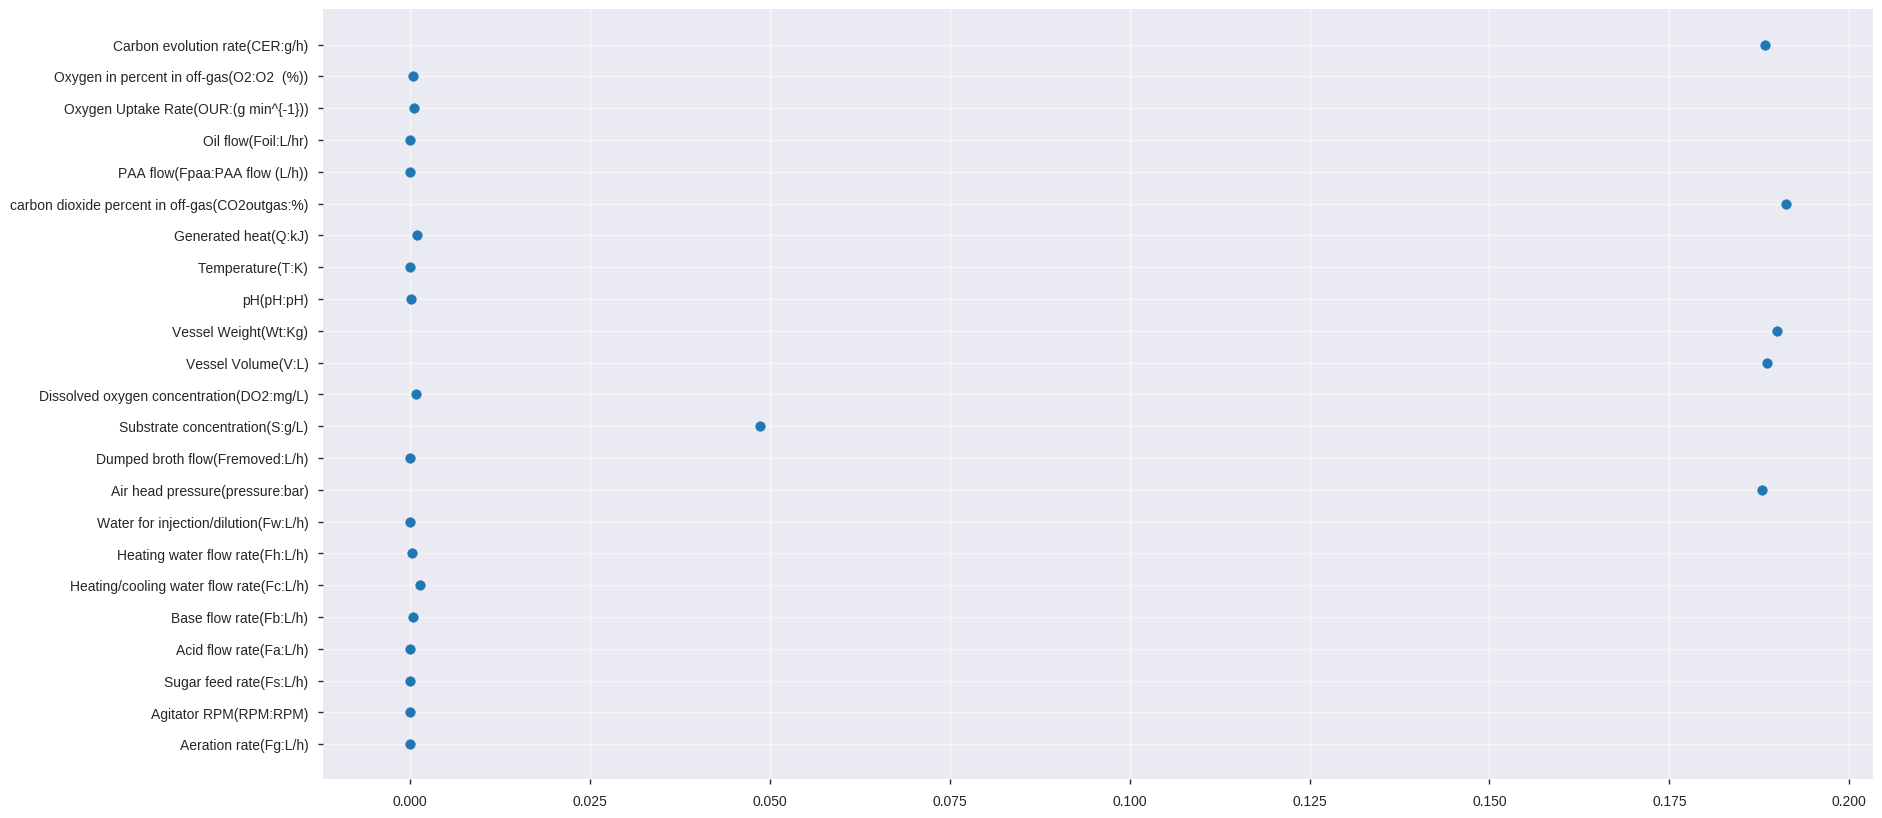

In [45]:
feats = rfr_r.feature_importances_
cols = var_rec_diff.columns.drop(['Penicillin concentration(P:g/L)'])
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(feats,cols)
ax.grid(alpha=.6)

![alt text](https://i.imgur.com/hi5nMTr.jpg)

In [0]:
#creating a dataframe to store feature importance data
boost_df = pd.DataFrame()
boost_df['rfr_r'] = rfr_r.feature_importances_

In [0]:
from sklearn.metrics import mean_squared_error

In [0]:
boost_df.set_index(var_rec_diff.columns.drop(['Penicillin concentration(P:g/L)']), inplace=True)

In [0]:
rfr_o = rfr.fit(X_o,Y_o)

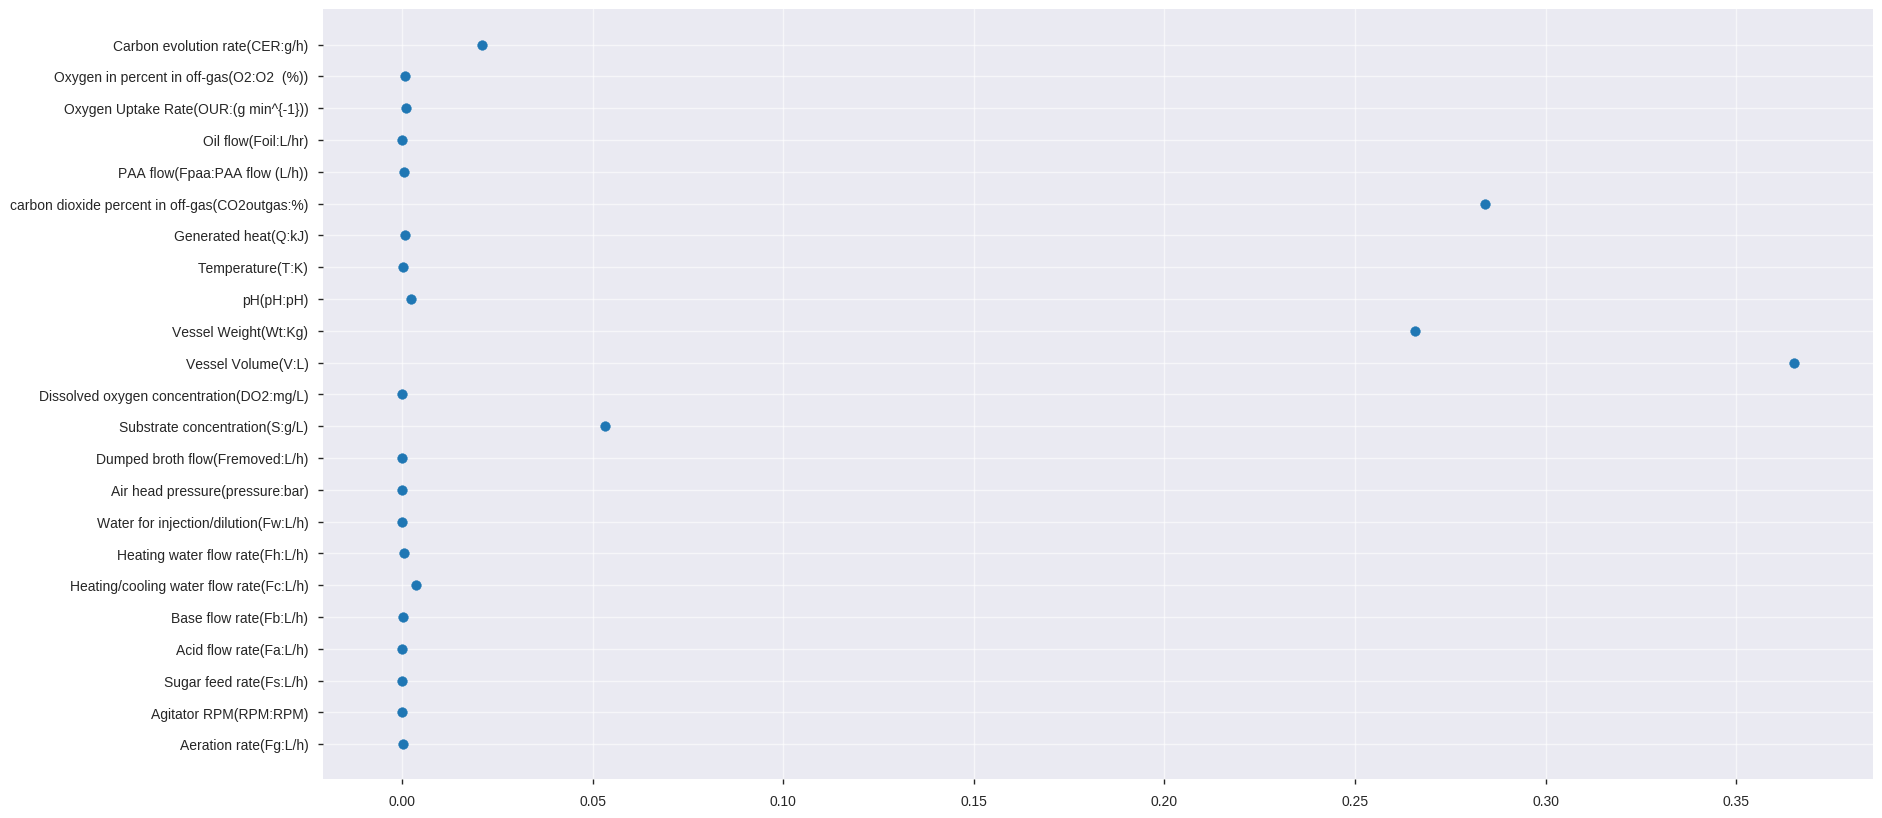

In [49]:
feats = rfr_o.feature_importances_
cols = var_op_diff.columns.drop(['Penicillin concentration(P:g/L)'])
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(feats,cols)
ax.grid(alpha=.6)

![alt text](https://i.imgur.com/tOAkHpr.jpg)

In [0]:
boost_df['rfr_o'] = rfr_o.feature_importances_

In [0]:
rfr_a = rfr.fit(X_a,Y_a)

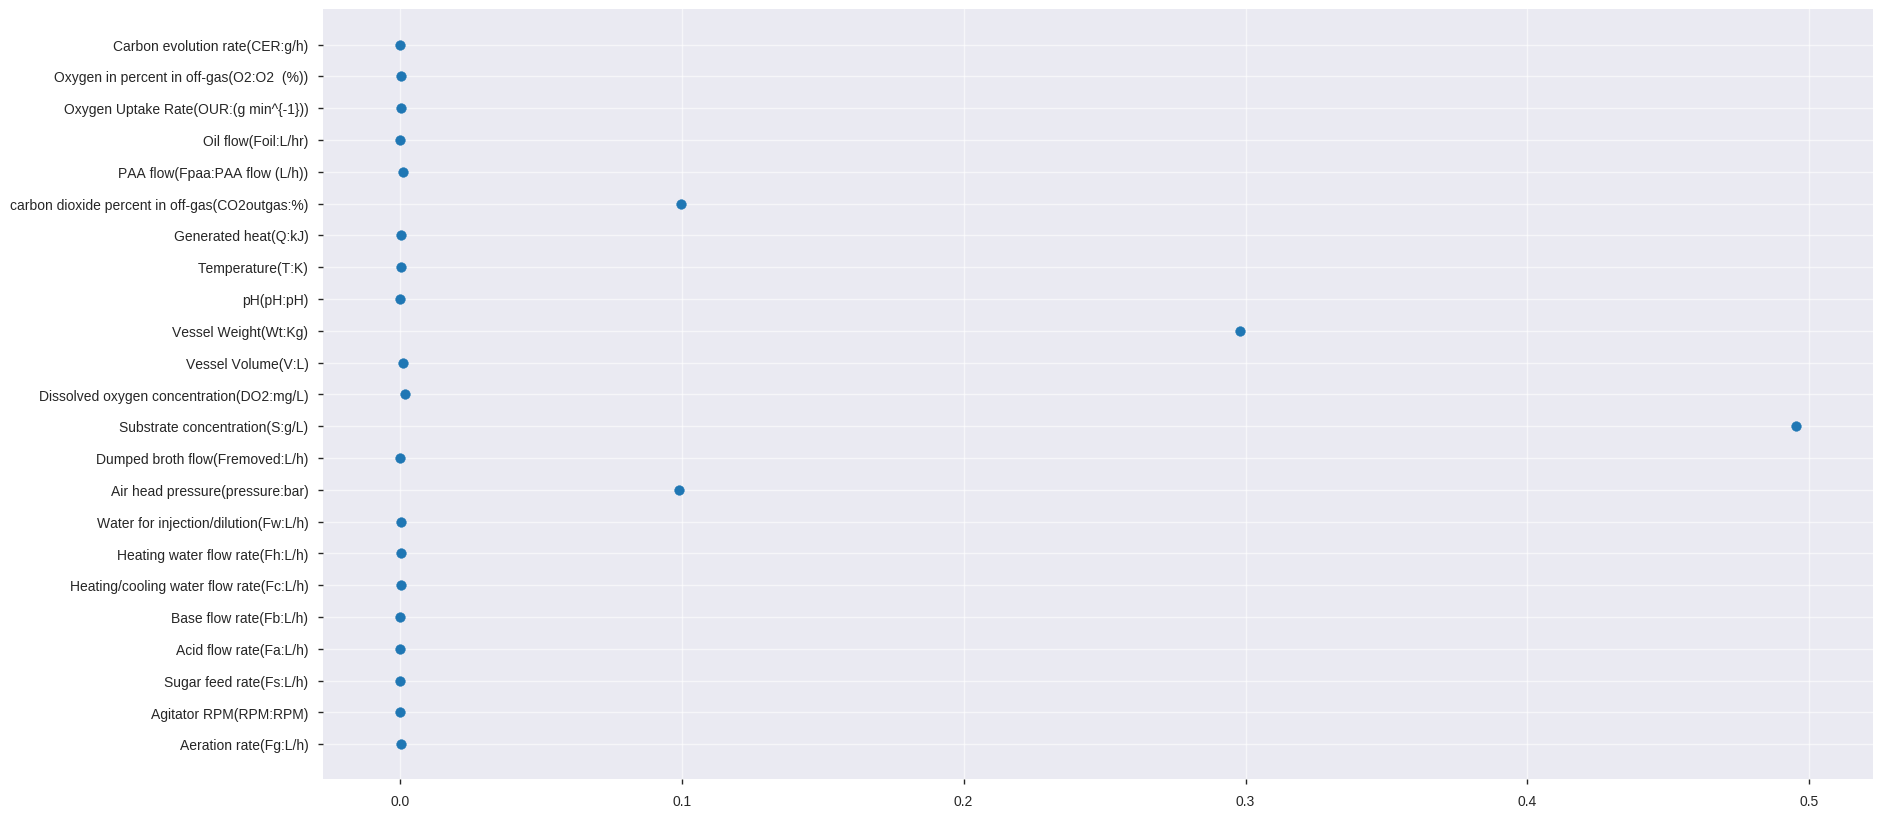

In [52]:
feats = rfr_a.feature_importances_
cols = var_APC_diff.columns.drop(['Penicillin concentration(P:g/L)'])
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(feats,cols)
ax.grid(alpha=.6)

![alt text](https://i.imgur.com/erxTozB.jpg)

In [0]:
boost_df['rfr_a'] = rfr_a.feature_importances_

In [60]:
y_true = var_rec_diff['Penicillin concentration(P:g/L)']
y_pred = rfr_r.predict(X_r)
MSE = mean_squared_error(y_true, y_pred)
print('The mean squared error of the random forest regressor on the recipe control group is {}'.format(MSE))

The mean squared error of the random forest regressor on the recipe control group is 0.01073512032225097


In [61]:
y_true = var_op_diff['Penicillin concentration(P:g/L)']
y_pred = rfr_o.predict(X_o)
MSE = mean_squared_error(y_true, y_pred)
print('The mean squared error of the random forest regressor on the operator control group is {}'.format(MSE))

The mean squared error of the random forest regressor on the operator control group is 0.059842404245984485


In [62]:
y_true = var_APC_diff['Penicillin concentration(P:g/L)']
y_pred = rfr_a.predict(X_a)
MSE = mean_squared_error(y_true, y_pred)
print('The mean squared error of the random forest regressor on the APC control group is {}'.format(MSE))

The mean squared error of the random forest regressor on the APC control group is 0.0010097413718139084


Below I will run the same feature importance test on a Gradient Boosting model.

In [0]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'random_state': 42}

In [0]:
clf = ensemble.GradientBoostingRegressor(**params)

In [56]:
from time import time
start = time()
scores['gbr_recipe'] = cross_val_score(clf, X_r, Y_r, cv=10)
scores['gbr_operator'] = cross_val_score(clf, X_o, Y_o, cv=10)
scores['gbr_APC'] = cross_val_score(clf, X_a, Y_a, cv=10)

print(time() - start)

616.0758490562439


![alt text](https://i.imgur.com/sfL0oZq.jpg)
![alt text](https://i.imgur.com/HbevB90.jpg)

In [57]:
scores

,rfr_recipe,rfr_operator,rfr_APC,gbr_recipe,gbr_operator,gbr_APC
0,0.997040,0.990087,0.996671,0.999662,0.994690,0.993899
1,0.915045,0.922718,0.996517,0.841137,0.925674,0.991514
2,0.996569,0.976707,0.971982,0.994176,0.967148,0.969418
3,0.980992,0.992119,0.997579,0.996412,0.963731,0.994603
4,0.994646,0.585808,0.982346,0.997387,0.805904,0.980868
5,0.966322,0.961382,0.995296,0.985034,0.966758,0.997073
6,0.972284,0.963711,0.995797,0.952177,0.968121,0.998085
7,0.995062,0.959702,0.998361,0.994808,0.972439,0.987227
8,0.986070,0.996100,0.995491,0.996466,0.968177,0.990441
9,0.960921,0.955351,0.982791,0.978101,0.957201,0.972026


In [58]:
print('The standard deviation of the random forest recipe control group is {0}.'.format(np.std(scores.rfr_recipe)))
print('The standard deviation of the random forest operator control group is {0}.'.format(np.std(scores.rfr_operator)))
print('The standard deviation of the random forest APC control group is {0}.'.format(np.std(scores.rfr_APC)))
print('The mean of the random forest recipe control group is {0}.'.format(np.mean(scores.rfr_recipe)))
print('The mean of the random forest operator control group is {0}.'.format(np.mean(scores.rfr_operator)))
print('The mean of the random forest APC control group is {0}.'.format(np.mean(scores.rfr_APC)))
print('The standard deviation of the gradient boost recipe control group is {0}.'.format(np.std(scores.gbr_recipe)))
print('The standard deviation of the gradient boost operator control group is {0}.'.format(np.std(scores.gbr_operator)))
print('The standard deviation of the gradient boost APC control group is {0}.'.format(np.std(scores.gbr_APC)))
print('The mean of the gradient boost recipe control group is {0}.'.format(np.mean(scores.gbr_recipe)))
print('The mean of the gradient boost operator control group is {0}.'.format(np.mean(scores.gbr_operator)))
print('The mean of the gradient boost APC control group is {0}.'.format(np.mean(scores.gbr_APC)))

The standard deviation of the random forest recipe control group is 0.023981309944635185.
The standard deviation of the random forest operator control group is 0.1166988378362821.
The standard deviation of the random forest APC control group is 0.008513780760671079.
The mean of the random forest recipe control group is 0.9764950739711468.
The mean of the random forest operator control group is 0.9303683951037062.
The mean of the random forest APC control group is 0.9912829730595998.
The standard deviation of the gradient boost recipe control group is 0.04617121770654353.
The standard deviation of the gradient boost operator control group is 0.05031878012392144.
The standard deviation of the gradient boost APC control group is 0.009645237449559576.
The mean of the gradient boost recipe control group is 0.9735361634682308.
The mean of the gradient boost operator control group is 0.9489842861647272.
The mean of the gradient boost APC control group is 0.9875153117483177.


In [0]:
gbr_r = clf.fit(X_r,Y_r)

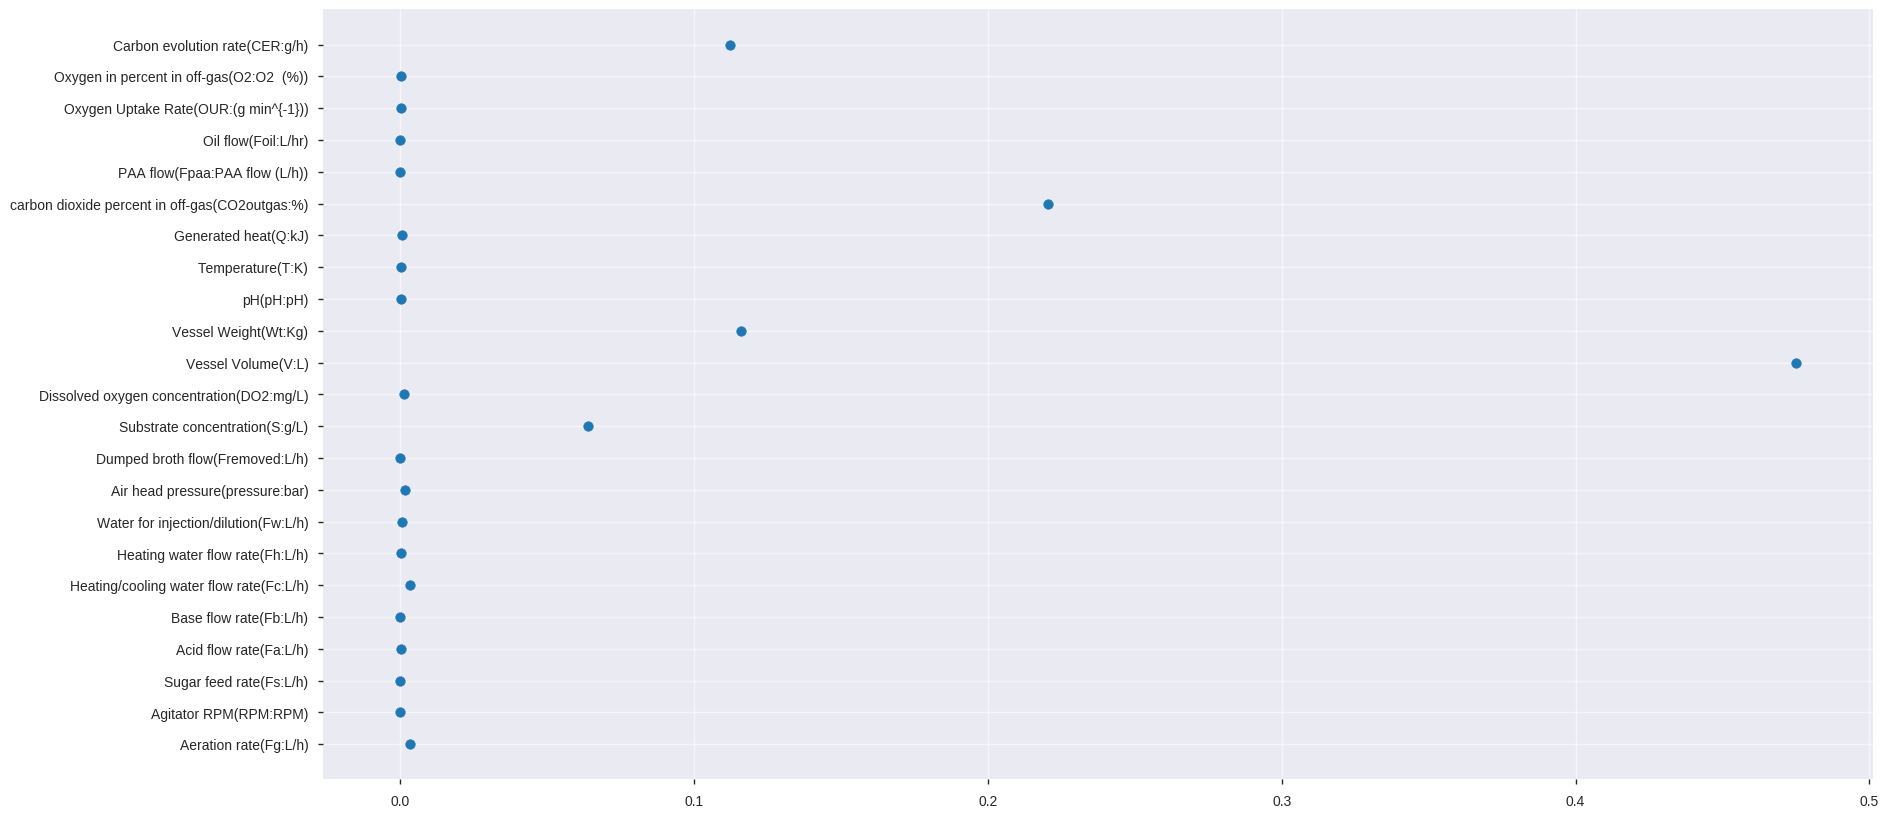

In [64]:
feats = gbr_r.feature_importances_
cols = var_rec_diff.columns.drop(['Penicillin concentration(P:g/L)'])
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(feats,cols)
ax.grid(alpha=.6)

![alt text](https://i.imgur.com/CgvZjfl.jpg)

In [0]:
boost_df['gbr_r'] = gbr_r.feature_importances_

In [0]:
gbr_o = clf.fit(X_o,Y_o)

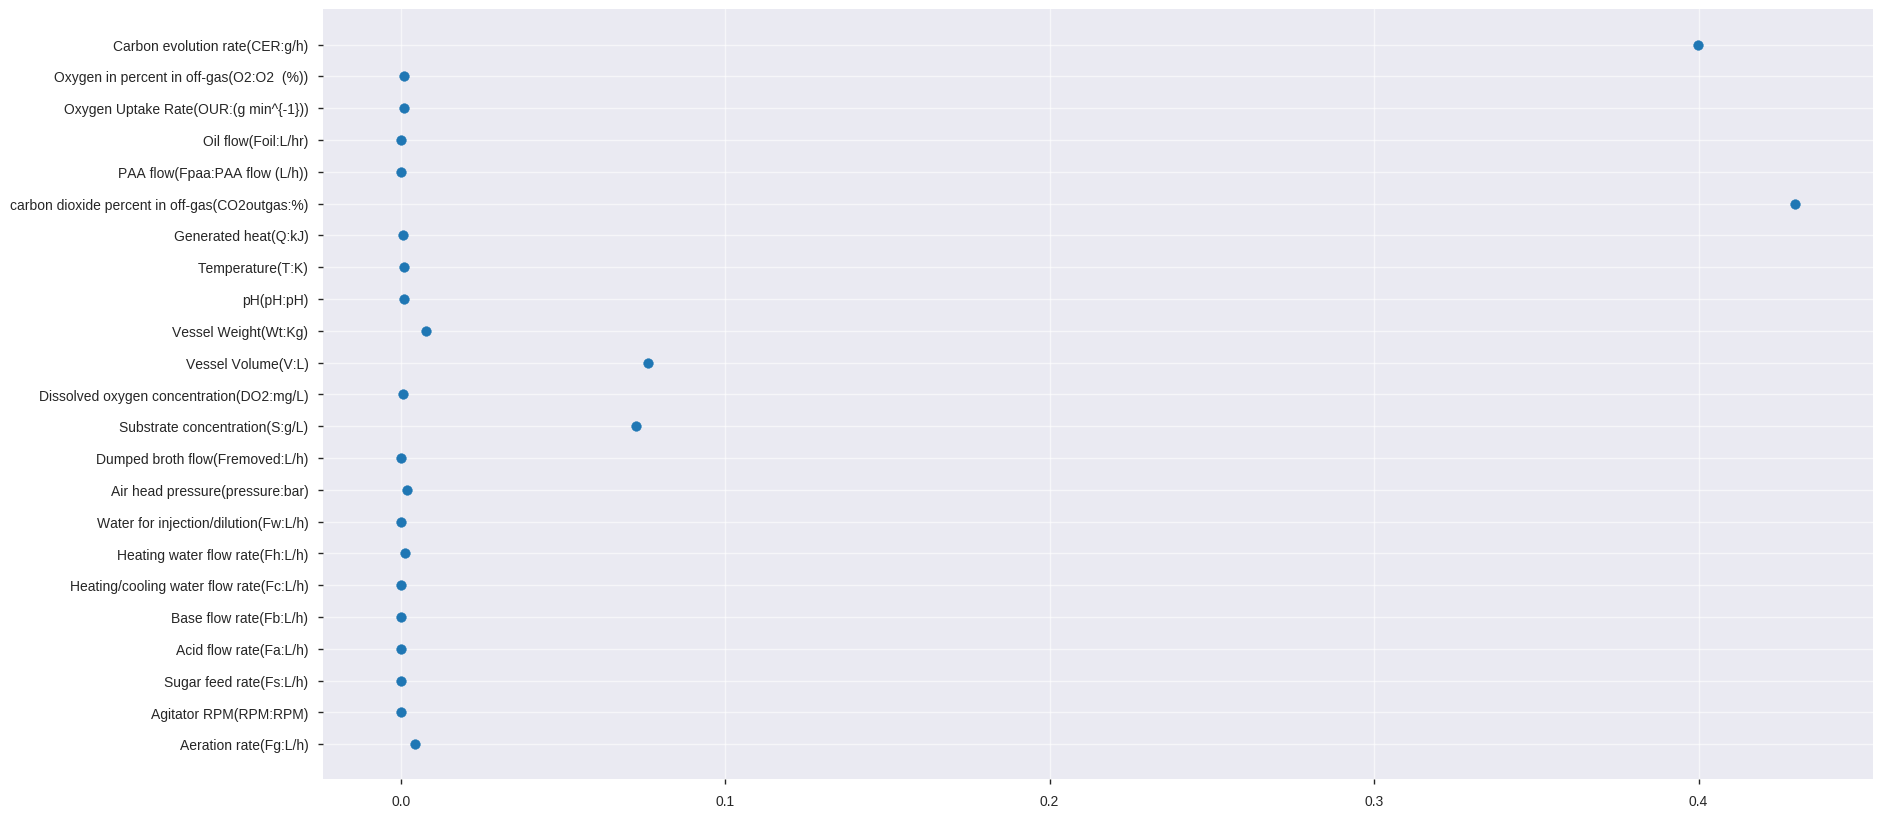

In [67]:
feats = gbr_o.feature_importances_
cols = var_op_diff.columns.drop(['Penicillin concentration(P:g/L)'])
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(feats,cols)
ax.grid(alpha=.6)

![alt text](https://i.imgur.com/sloFMd8.jpg)

In [0]:
boost_df['gbr_o'] = gbr_o.feature_importances_

In [0]:
gbr_a = clf.fit(X_a,Y_a)

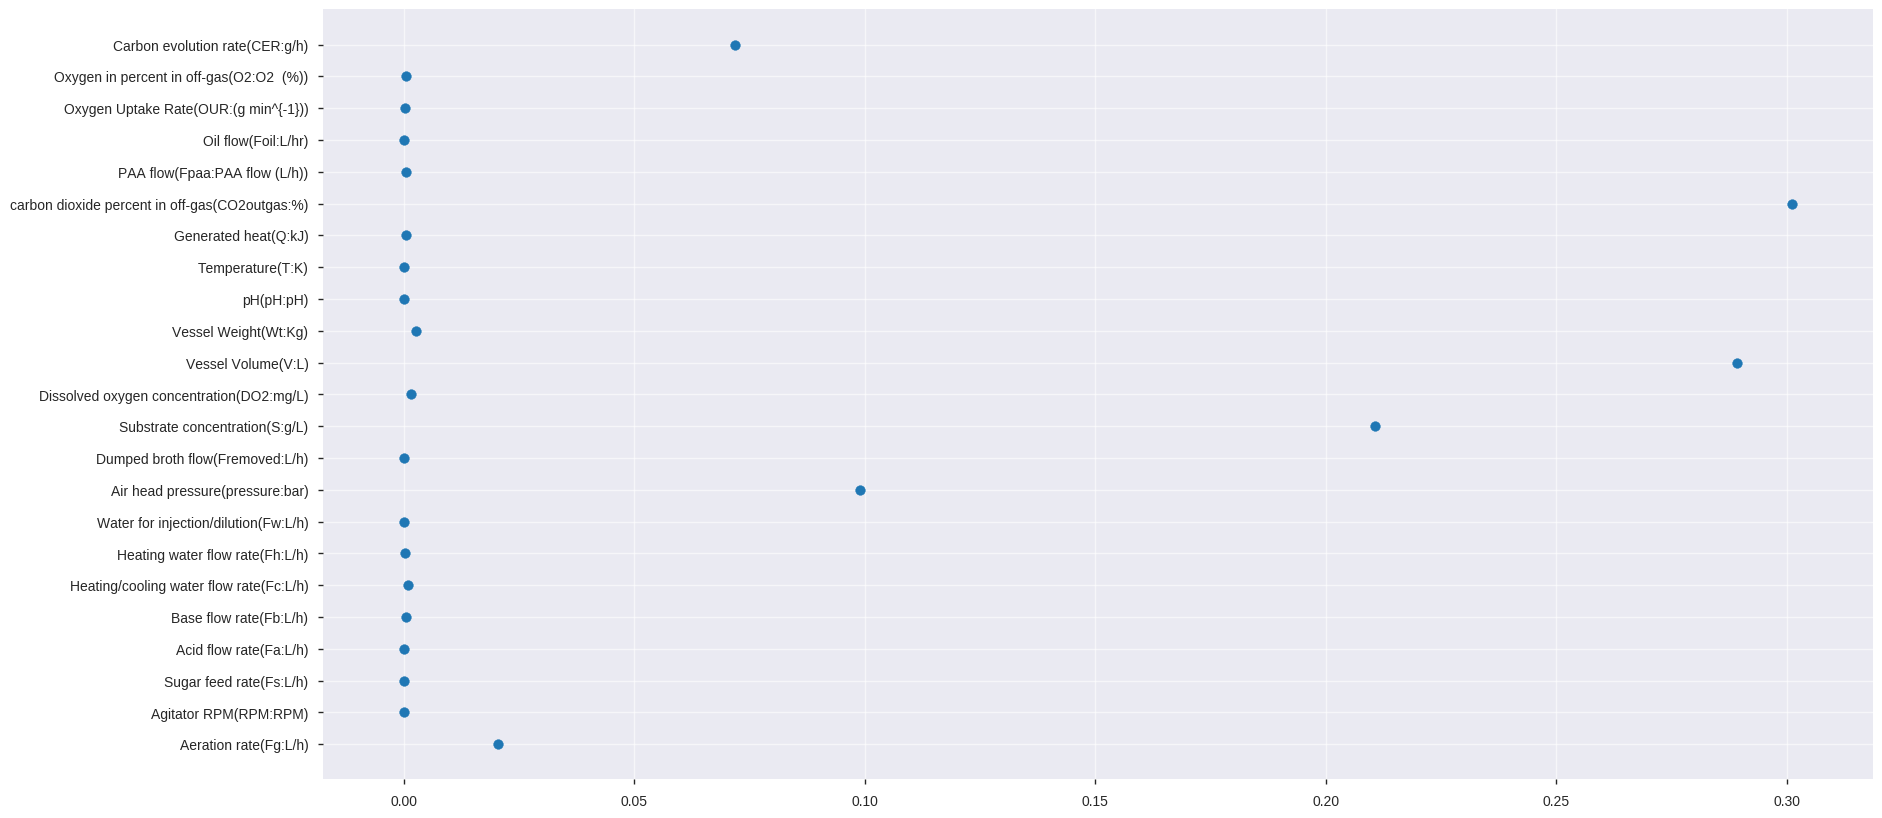

In [70]:
feats = gbr_a.feature_importances_
cols = var_APC_diff.columns.drop(['Penicillin concentration(P:g/L)'])
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(feats,cols)
ax.grid(alpha=.6)

![alt text](https://i.imgur.com/lrNR2Zl.jpg)

In [0]:
boost_df['gbr_a'] = gbr_a.feature_importances_

In [72]:
y_true = var_rec_diff['Penicillin concentration(P:g/L)']
y_pred = gbr_r.predict(X_r)
MSE = mean_squared_error(y_true, y_pred)
print('The mean squared error of the gradient boosting regressor on the recipe control group is {}'.format(MSE))

The mean squared error of the gradient boosting regressor on the recipe control group is 0.017390236832596034


In [73]:
y_true = var_op_diff['Penicillin concentration(P:g/L)']
y_pred = gbr_o.predict(X_o)
MSE = mean_squared_error(y_true, y_pred)
print('The mean squared error of the gradient boosting regressor on the operator control group is {}'.format(MSE))

The mean squared error of the gradient boosting regressor on the operator control group is 0.038797471782097255


In [74]:
y_true = var_APC_diff['Penicillin concentration(P:g/L)']
y_pred = gbr_a.predict(X_a)
MSE = mean_squared_error(y_true, y_pred)
print('The mean squared error of the gradient boosting regressor on the APC control group is {}'.format(MSE))

The mean squared error of the gradient boosting regressor on the APC control group is 9.126008024285892e-06



Create a list of the high impact features for each control group. Use each list to run a seperate SVR and compare the scores.

In [75]:
boost_df

,rfr_r,rfr_o,rfr_a,gbr_r,gbr_o,gbr_a
Aeration rate(Fg:L/h),2.545449e-08,2.712227e-04,4.871650e-04,3.278522e-03,4.273195e-03,2.052448e-02
Agitator RPM(RPM:RPM),0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Sugar feed rate(Fs:L/h),3.149784e-06,9.464897e-05,1.452454e-07,1.106138e-06,8.961386e-06,4.919087e-07
Acid flow rate(Fa:L/h),8.901877e-08,2.361054e-07,3.998588e-08,1.875529e-04,1.437828e-04,5.184219e-08
Base flow rate(Fb:L/h),4.759152e-04,2.892569e-04,1.284937e-04,8.100746e-05,1.888941e-04,4.813315e-04
Heating/cooling water flow rate(Fc:L/h),1.436903e-03,3.592992e-03,4.128252e-04,3.389545e-03,1.901194e-04,8.086073e-04
Heating water flow rate(Fh:L/h),3.827139e-04,4.096170e-04,2.875018e-04,2.490079e-04,1.464234e-03,2.853703e-04
Water for injection/dilution(Fw:L/h),2.129807e-06,3.144276e-06,6.055680e-04,5.440089e-04,3.801687e-06,1.962992e-08
Air head pressure(pressure:bar),1.878032e-01,4.513563e-09,9.892782e-02,1.560277e-03,2.046403e-03,9.904372e-02
Dumped broth flow(Fremoved:L/h),3.566168e-07,5.048642e-08,1.209914e-05,8.257761e-07,6.269161e-07,1.155695e-04


In [76]:
boost_t = boost_df.T
boost_t

,Aeration rate(Fg:L/h),Agitator RPM(RPM:RPM),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),Dumped broth flow(Fremoved:L/h),Substrate concentration(S:g/L),Dissolved oxygen concentration(DO2:mg/L),Vessel Volume(V:L),Vessel Weight(Wt:Kg),pH(pH:pH),Temperature(T:K),Generated heat(Q:kJ),carbon dioxide percent in off-gas(CO2outgas:%),PAA flow(Fpaa:PAA flow (L/h)),Oil flow(Foil:L/hr),Oxygen Uptake Rate(OUR:(g min^{-1})),Oxygen in percent in off-gas(O2:O2 (%)),Carbon evolution rate(CER:g/h)
rfr_r,2.545449e-08,0.0,3.149784e-06,8.901877e-08,0.000476,0.001437,0.000383,2.129807e-06,1.878032e-01,3.566168e-07,0.048726,0.000875,0.188502,0.189966,0.000162,0.000076,0.000981,0.191226,1.165297e-06,5.273115e-08,0.000560,0.000518,0.188302
rfr_o,2.712227e-04,0.0,9.464897e-05,2.361054e-07,0.000289,0.003593,0.000410,3.144276e-06,4.513563e-09,5.048642e-08,0.053301,0.000050,0.365125,0.265850,0.002486,0.000175,0.000912,0.284042,5.900613e-04,4.848280e-07,0.001018,0.000862,0.020929
rfr_a,4.871650e-04,0.0,1.452454e-07,3.998588e-08,0.000128,0.000413,0.000288,6.055680e-04,9.892782e-02,1.209914e-05,0.495297,0.002005,0.001072,0.298174,0.000041,0.000281,0.000508,0.099769,1.214516e-03,2.742453e-09,0.000333,0.000259,0.000186
gbr_r,3.278522e-03,0.0,1.106138e-06,1.875529e-04,0.000081,0.003390,0.000249,5.440089e-04,1.560277e-03,8.257761e-07,0.063878,0.001345,0.474980,0.115947,0.000395,0.000344,0.000621,0.220403,1.909946e-08,2.407421e-08,0.000212,0.000187,0.112397
gbr_o,4.273195e-03,0.0,8.961386e-06,1.437828e-04,0.000189,0.000190,0.001464,3.801687e-06,2.046403e-03,6.269161e-07,0.072593,0.000722,0.076184,0.007637,0.001111,0.001130,0.000661,0.429758,1.045812e-04,1.968371e-09,0.000857,0.001093,0.399830
gbr_a,2.052448e-02,0.0,4.919087e-07,5.184219e-08,0.000481,0.000809,0.000285,1.962992e-08,9.904372e-02,1.155695e-04,0.210603,0.001507,0.289263,0.002571,0.000073,0.000020,0.000385,0.301137,5.389449e-04,2.165677e-07,0.000338,0.000512,0.071792


In [77]:
var_rec_diff.head()

,Aeration rate(Fg:L/h),Agitator RPM(RPM:RPM),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),Dumped broth flow(Fremoved:L/h),Substrate concentration(S:g/L),Dissolved oxygen concentration(DO2:mg/L),Penicillin concentration(P:g/L),Vessel Volume(V:L),Vessel Weight(Wt:Kg),pH(pH:pH),Temperature(T:K),Generated heat(Q:kJ),carbon dioxide percent in off-gas(CO2outgas:%),PAA flow(Fpaa:PAA flow (L/h)),Oil flow(Foil:L/hr),Oxygen Uptake Rate(OUR:(g min^{-1})),Oxygen in percent in off-gas(O2:O2 (%)),Carbon evolution rate(CER:g/h)
1,0.0,0.0,0.0,0.0000,21.1030,8.3215,0.0,0.0,0.0,0.0,0.04711,-0.012,1.000000e-03,8.0,11.0,0.0460,-0.05,0.0,0.012246,0.0,0.0,-0.422363,0.00795,0.004657
2,0.0,0.0,0.0,0.0000,3.0810,-8.5568,0.0,0.0,0.0,0.0,0.04520,-0.013,-6.600000e-07,8.0,13.0,0.0493,-0.03,0.0,0.004040,0.0,0.0,-0.099652,0.00185,0.001538
3,0.0,0.0,0.0,0.0000,-16.4860,-5.2587,0.0,0.0,0.0,0.0,0.04440,-0.025,-6.000000e-07,4.0,9.0,0.0328,-0.03,0.0,0.002390,0.0,0.0,-0.015232,0.00027,0.000909
4,0.0,0.0,0.0,0.5181,-18.9080,-3.2350,0.0,0.0,0.0,0.0,0.04280,-0.028,-5.300000e-07,2.0,6.0,0.0072,-0.02,0.0,0.002110,0.0,0.0,0.006762,-0.00013,0.000802
5,0.0,0.0,0.0,0.5206,-9.4539,-1.1044,0.0,0.0,0.0,0.0,0.04120,-0.012,-5.000000e-07,-1.0,4.0,-0.0108,-0.01,0.0,0.002120,0.0,0.0,0.004708,-0.00009,0.000807


In [0]:
google_csv(boost_t)

New dataframes which contain only the most significant features from each model. These will be used to boost AdaBoost models for comparison.

In [0]:
var_rec_diff_boost_r = var_rec_diff[boost_t.columns[np.where(boost_t.loc['rfr_r'] > 0.01)]]
var_op_diff_boost_r = var_op_diff[boost_t.columns[np.where(boost_t.loc['rfr_o'] > 0.01)]]
var_APC_diff_boost_r = var_APC_diff[boost_t.columns[np.where(boost_t.loc['rfr_a'] > 0.01)]]
var_rec_diff_boost_g = var_rec_diff[boost_t.columns[np.where(boost_t.loc['gbr_r'] > 0.01)]]
var_op_diff_boost_g = var_op_diff[boost_t.columns[np.where(boost_t.loc['gbr_o'] > 0.01)]]
var_APC_diff_boost_g = var_APC_diff[boost_t.columns[np.where(boost_t.loc['gbr_a'] > 0.01)]]

In [0]:
from sklearn import linear_model
from sklearn.ensemble import AdaBoostRegressor

In [0]:
clf_a = AdaBoostRegressor(n_estimators=100, random_state=42)

In [0]:
Xbr_r = var_rec_diff_boost_r
Ybr_r = var_rec_diff['Penicillin concentration(P:g/L)']
Xbr_o = var_op_diff_boost_r
Ybr_o = var_op_diff['Penicillin concentration(P:g/L)']
Xbr_a = var_APC_diff_boost_r
Ybr_a = var_APC_diff['Penicillin concentration(P:g/L)']

In [0]:
Xbg_r = var_rec_diff_boost_g
Ybg_r = var_rec_diff['Penicillin concentration(P:g/L)']
Xbg_o = var_op_diff_boost_g
Ybg_o = var_op_diff['Penicillin concentration(P:g/L)']
Xbg_a = var_APC_diff_boost_g
Ybg_a = var_APC_diff['Penicillin concentration(P:g/L)']

In [0]:
scores['ADA_recipe_r'] = cross_val_score(clf_a, Xbr_r, Ybr_r, cv=10)
scores['ADA_operator_r'] = cross_val_score(clf_a, Xbr_o, Ybr_o, cv=10)
scores['ADA_APC_r'] = cross_val_score(clf_a, Xbr_a, Ybr_a, cv=10)

In [84]:
scores

,rfr_recipe,rfr_operator,rfr_APC,gbr_recipe,gbr_operator,gbr_APC,ADA_recipe_r,ADA_operator_r,ADA_APC_r
0,0.997040,0.990087,0.996671,0.999662,0.994690,0.993899,0.998745,0.994307,0.988054
1,0.915045,0.922718,0.996517,0.841137,0.925674,0.991514,0.958011,0.977205,0.998153
2,0.996569,0.976707,0.971982,0.994176,0.967148,0.969418,0.988813,0.942385,0.962493
3,0.980992,0.992119,0.997579,0.996412,0.963731,0.994603,0.981636,0.981742,0.999648
4,0.994646,0.585808,0.982346,0.997387,0.805904,0.980868,0.994326,0.783078,0.996460
5,0.966322,0.961382,0.995296,0.985034,0.966758,0.997073,0.979558,0.937184,0.993557
6,0.972284,0.963711,0.995797,0.952177,0.968121,0.998085,0.909459,0.969384,0.995147
7,0.995062,0.959702,0.998361,0.994808,0.972439,0.987227,0.989920,0.970630,0.992193
8,0.986070,0.996100,0.995491,0.996466,0.968177,0.990441,0.993728,0.989513,0.992354
9,0.960921,0.955351,0.982791,0.978101,0.957201,0.972026,0.987766,0.969019,0.986320


In [0]:
scores['ADA_recipe_g'] = cross_val_score(clf_a, Xbg_r, Ybg_r, cv=10)
scores['ADA_operator_g'] = cross_val_score(clf_a, Xbg_o, Ybg_o, cv=10)
scores['ADA_APC_g'] = cross_val_score(clf_a, Xbg_a, Ybg_a, cv=10)

In [86]:
scores

,rfr_recipe,rfr_operator,rfr_APC,gbr_recipe,gbr_operator,gbr_APC,ADA_recipe_r,ADA_operator_r,ADA_APC_r,ADA_recipe_g,ADA_operator_g,ADA_APC_g
0,0.997040,0.990087,0.996671,0.999662,0.994690,0.993899,0.998745,0.994307,0.988054,0.996641,0.994307,0.998591
1,0.915045,0.922718,0.996517,0.841137,0.925674,0.991514,0.958011,0.977205,0.998153,0.961401,0.979602,0.994210
2,0.996569,0.976707,0.971982,0.994176,0.967148,0.969418,0.988813,0.942385,0.962493,0.983559,0.942385,0.979206
3,0.980992,0.992119,0.997579,0.996412,0.963731,0.994603,0.981636,0.981742,0.999648,0.983097,0.991463,0.999309
4,0.994646,0.585808,0.982346,0.997387,0.805904,0.980868,0.994326,0.783078,0.996460,0.994326,0.783191,0.992979
5,0.966322,0.961382,0.995296,0.985034,0.966758,0.997073,0.979558,0.937184,0.993557,0.979558,0.937184,0.993488
6,0.972284,0.963711,0.995797,0.952177,0.968121,0.998085,0.909459,0.969384,0.995147,0.965893,0.968494,0.996564
7,0.995062,0.959702,0.998361,0.994808,0.972439,0.987227,0.989920,0.970630,0.992193,0.989920,0.970630,0.992455
8,0.986070,0.996100,0.995491,0.996466,0.968177,0.990441,0.993728,0.989513,0.992354,0.993728,0.962291,0.994768
9,0.960921,0.955351,0.982791,0.978101,0.957201,0.972026,0.987766,0.969019,0.986320,0.987766,0.973701,0.979016


![alt text](https://i.imgur.com/aSwt6wA.jpg)
![alt text](https://i.imgur.com/UDTFf7e.jpg)

In [0]:
google_csv(scores)

[Here is a link to my presentation](https://docs.google.com/presentation/d/1YkY72HYbLh3MtPPxyoxndb7me2kDQlyHfPqOhwDhQjk/edit?usp=sharing)

**Research Goal**: To increase cost efficiency of commercial scale penicillin synthesis.
Specifically,
Predicting the most influential features on final concentration.
Using these features to reduce the sensor hardware required.
Completing these goals without loss of product quality.


**Why I chose this dataset**: I wanted to get experience working with large amounts of data. I felt this was a good time for me to challenge myself by working with data that I am unfamiliar with. I wanted to work with data that would be relevant for all of the bio-tech companies near me.

**Why I chose my model**: Random Forest and Gradient Boosting. They aren't black boxes, they can handle regression, and have high accuracy. These are models that I have recently learned and they interest me. I chose to compare them using an AdaBoost because of the size of the datasets, and because it is highly accurate.

**The practical uses of my model**: It could help to inform the industry professionals working on this synthesis on which features are having the largest impact. This knowledge could be applied to save money on sensors, tests, and time spent.

**Weak points**: These models cannot handle non-stationary time series', so I had to stationarize all of the data. A future research idea would be to compare my findings against model such as ARIMA to predict which features have the largest effect at specific times during the synthesis process.


The highest performing model is the Gradient Boost run on the APC control group. 

The most predictive features are:
Carbon dioxide percent in off-gas
Vessel Volume
Substrate Concentration
Airhead Pressure
Carbon Evolution Rate
Aeration Rate

By measuring these 6 features we will be able to know the penicillin concentration with over 99% accuracy.
